# Assignment 1 - CSCI 5901 The Process of Data Science
###### A1_AbhinandanWalia_ManpreetSingh
###### Abhinandan Walia : B00820613
###### Manpreet Singh : B00821998

### 1. Inroduction

The dataset provided for this assignment is list of restaurants in Bengaluru (India) collected by Zomato (Indian restaurants search and discovery service). The dataset has various attributes that helps in analysing the demographics of the restaurants based on location. Attributes like “URL, Address, Name, Phone, Location and Listed_in(city)” provides the basic information about the restaurant. This data is useful for finding the restaurant based on the location or name. 
Other attributes like “Online_order, Book_table, menu_item, rest_type,dish_like, cuisines, listed_in(type) and approx_cost(for two people)” contains data about the restaurant features and food option they offer. 
The remaining attributes like “Rating, Votes, and Review_list” provide the data that is useful for analysing the likes and dislikes for a restaurant by the customers. These attributes shows the trends in ratings and reviews about the restaurant aesthetics and food offered.


In [2]:
import sklearn
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import re
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

### Data pre-processing and Understanding
##### Loading the Data
Pandas have been used to load the data from the csv.The csv file was converted into 'utf-8' format before opening it.

In [3]:
#load data from csv
dataFrame = pd.read_csv("zomato.csv",encoding="utf-8")

### 2. Exploring the data
The irrelevant attributes were removed from the data first, which are URL,address,online_order,book_table,votes,phone, dish_liked,reviews_list,menu_item,listed_in,listed_in_city.Because we have to calculate the approximate cost for 2 people in a restraunt,there is no point considering the attributes like URL,menu_item. The final attributes which were selected based on the information provided by them, which are required to build the model, are:

> name, 
> rate, 
> location, 
> rest_type, 
> cuisines, 
> approx_cost(for two people)

The restaurants which have similar name and location have been removed from the data.

In [4]:
#Reference: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html

#Removed column url,address,online_order,book_table,votes,phone,dish_liked,reviews_list,menu_item,listed_in,listed_in_city
dataFrame.drop(dataFrame.columns[[0,1,3,4,6,7,10,13,14,15,16]], axis=1, inplace=True)

######  Sort data and remove duplicate restaurants
Sorting the data based on the name of the restaurant and removed the duplicate restaurants.The column 'approx_cost(for two people)' was renamed to 'cost' as it contains reserved keyword 'for'.

In [5]:
#Reference:https://www.geeksforgeeks.org/python-pandas-dataframe-drop_duplicates/
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html

#drop duplicate restraunts with same name and same location
dataFrame = dataFrame.sort_values('name', ascending=False)
dataFrame = dataFrame.drop_duplicates(subset=['name', 'location'], keep='first')
dataFrame.rename(columns={'approx_cost(for two people)':'cost'}, inplace=True)

###### Cleaning the data
The cost column was converted to numeric because it contained alphabets for many records and null values.The rating of a restraunt was out of 5.So, the data after '/' was ommitted.The 'name' field contained special characters that is why it was converted into ASCII format.

In [6]:
#Reference:https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.to_numeric.html
#https://www.programiz.com/python-programming/methods/string/encode

#cleaning the data
dataFrame = dataFrame[pd.to_numeric(dataFrame['cost'], errors='coerce').notnull()]
dataFrame['rate'] = dataFrame['rate'].str.split('/').str[0]
dataFrame = dataFrame[pd.to_numeric(dataFrame['rate'], errors='coerce').notnull()]
dataFrame['name'] = dataFrame['name'].str.encode('ascii', 'ignore').str.decode('ascii')

###### Plotting the Frequency Distribution
###### In the bar graph below top 20 restaurants have been plotted against the count of each restaurant.

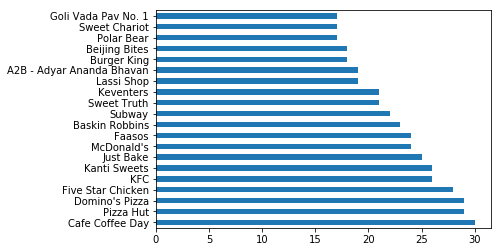

In [7]:
#Reference: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html

#plotting the frequency distribution
#plotting the first 20 unique restraunts present in maximum number of locations
uniqueRestraunts = np.unique(dataFrame.name)
dataFrame['name'].value_counts()[:20].plot(kind='barh')

###### Top 20 unique Ratings present in the data set have been represented below in the bar graph

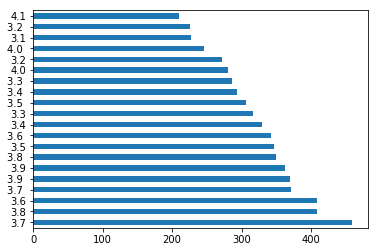

In [8]:
#plotting the top 20 unique ratings as per the dataset
uniqueRatings = np.unique(dataFrame.rate)
dataFrame['rate'].value_counts()[:20].plot(kind='barh')

###### Top 20 unique locations present in the data set have been represented below in the bar graph

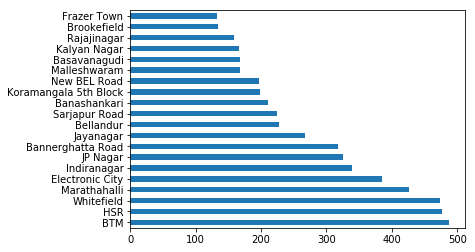

In [9]:
#plotting the top 20 unique locations 
uniqueLocations = np.unique(dataFrame.location)
dataFrame['location'].value_counts()[:20].plot(kind='barh')

###### Rating of the restaurants in the top 5 locations has been represented below

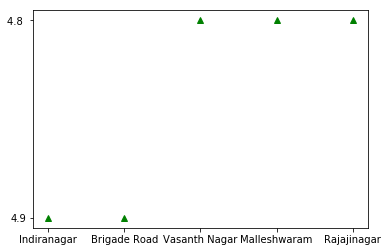

In [10]:
#Reference: https://matplotlib.org/users/pyplot_tutorial.html

#plotting the top 5 locations as per the rating
dataFrame = dataFrame.sort_values('rate', ascending=False)
x = dataFrame['location'].head(5)
y = dataFrame['rate'].head(5)
plt.plot(x,y,'g^')

######  Approximate cost of  a restaurant based on the cuisine

<BarContainer object of 10 artists>

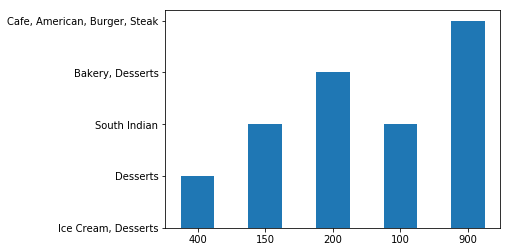

In [11]:
#plotting the approximate cost of mutiple cuisines 
cuisine_type = (dataFrame['cuisines'].head(10))
approx_cost = (dataFrame['cost'].head(10))
width = 0.5
plt.bar(approx_cost,cuisine_type,width)

######  Approximate cost of  a restaurant based on the restaurant type

<BarContainer object of 20 artists>

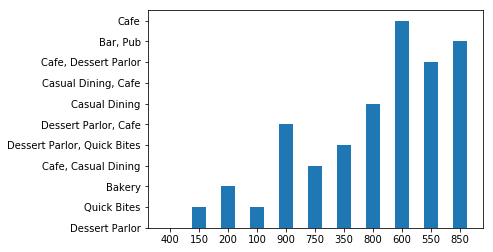

In [12]:
#plotting the restraunt type versus the approximate cost for top 20 restraunts types
rest_type = (dataFrame['rest_type'].head(20))
approx_cost = (dataFrame['cost'].head(20))
width = 0.5
plt.bar(approx_cost,rest_type,width)


### 3. Building the best Fit Model

For the data and the task given in this assignment, we are dealing with supervised regression problem. A supervised problem is one in which we try to map a input to a continous output. The main goal of these kind of problems is to find a feature that will help us to predict the output. A Classification Problem requires that the input is classified into one of the two or more classes whereas a Regression Problem requires the prediction of quantity. Since the Problem given requires to predict the Approximate Cost for two people in a resturant, it is a Regression Problem.

We are focused to build a model that could predict the cost after learning from training data. The first step in model building is to prepare the data in a format that is uniform and easy to understand by the model.

The attributes that are required to predict the output have different datatype i.e. 
> Cost, Rate = integer

> Rest_type, Cuisines, Location = string

"One Hot Encoding" has been implemented to bring the data to a consistent type. Pandas provide an inbuilt function "get_dummies" to convert the categorical column into indicator values.

In [13]:
#Reference for onehot encoding: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html

dataFrame.drop(dataFrame.columns[[0]], axis=1, inplace=True)
#one hot encoding to convert data to binary format
dataFrame=pd.concat([dataFrame,pd.get_dummies(dataFrame['location'],prefix='location')],axis=1).drop(['location'],axis=1)
dataFrame=pd.concat([dataFrame,pd.get_dummies(dataFrame['cuisines'],prefix='cuisines')],axis=1).drop(['cuisines'],axis=1)
dataFrame=pd.concat([dataFrame,pd.get_dummies(dataFrame['rest_type'],prefix='rest_type')],axis=1).drop(['rest_type'],axis=1)


#### Linear Regression

Linear Regression has been chosen because the attributes are independent from each other. Eg. Rating of a restaurant is not dependent on the location of the restaurant. It can easily indentify the outliers.

For evaluating the Linear Regression model, finding the Mean Squared Error and R2_Score turned out to be a suitable choice as they provide us with the good results.

R2 Score has been used as it determines that how closely the test data is fitted to the trained data.  

Mean Squared Error gives the average squared distance between the predicted output and the expected output.


In [14]:
#Reference: Lab 2 and 3

#Linear Regression
# Dividing the data to test and train set
x_train = dataFrame[:-2000]
x_test = dataFrame[-2000:]
# Dividing the target cost to test and train set
y_train = dataFrame.cost[:-2000]
y_test = dataFrame.cost[-2000:]
lr = linear_model.LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
print("Mean Squared Error:")
print( mean_squared_error(y_test, y_pred))
print("R2 Score: ")
print(r2_score(y_test, y_pred))

Mean Squared Error:
4.1395156575906057e-08
R2 Score: 
0.9999999999986833


In [15]:
#Reference: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
#https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
#https://docs.scipy.org/doc/numpy/reference/generated/numpy.array.html
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

labelledData = np.array(dataFrame['cost'])
dataFrame = dataFrame.drop('cost', axis = 1)
dataFrame_list = list(dataFrame.columns)
dataFrame = np.array(dataFrame)
#Split data to training and testing data
train_data, test_data, train_labelledData, test_labelledData = train_test_split(dataFrame, labelledData, test_size = 0.25, random_state = 42)
train_data = train_data.astype(float)
test_data = test_data.astype(float)
train_labelledData = train_labelledData.astype(float)
test_labelledData = test_labelledData.astype(float)

#### Random Forest Regressor

Random Forest Regressor is another regression model that uses ensemble learning to predict the output with more accuracy and avoids overfiting. 

For evaluating the Random Forest Regressor we have used Mean Absolute Error and R2 Score

Mean Absolute Error indicates how close the predicted output is to the actual data.

R2 Score has been used as it determines that how closely the test data is fitted to the trained data.

#### Avoiding Overfitting

1. Used "oob_score = True" and n_estimators with different values
2. As the number of features increase the model tends to overfit. Restricting to minimum features is the priority. 
3. To improve the model futher pre-pruning and post pruning can be used.
4. Calculating the point where we need to stop branching. This can be achieved using the Hypothesis Test.


In [16]:
# 200 estimators used to train the model
rf = RandomForestRegressor(n_estimators = 200,oob_score = True,n_jobs=-1,random_state = 42)
rf.fit(train_data, train_labelledData);
modelPrediction = rf.predict(test_data)
# Calculate error in the model
modelError = abs(modelPrediction - test_labelledData)
print('Model Error:', round(np.mean(modelError), 3))

Model Error: 94.261


In [17]:
#Calculating the accuracy of the model
meanAbsError = 100 * (modelError / test_labelledData)
modelAccuracy = 100 - np.mean(meanAbsError)
print('Model Accuracy:', round(modelAccuracy, 3), '%')

Model Accuracy: 70.602 %


##### Between Sample and Cross validation, we used cross validation because it ensures every data point from the original dataset appears atleast once in either training or test set. Also, it helps in avoiding overfiting in the model to great extent.

In [18]:
#Finding score using cross validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf, train_data, train_labelledData, scoring='r2', cv=2,n_jobs=1)
print('R2 Score')
print(scores)

R2 Score
[0.57286634 0.55997048]


##### The model gives us the approximate cost based on the rating of a restaurant. In below representation we can see the actual rating (rate) and the predicted rating (rate) by the model with respect to Approx Cost(Two People). 
Eg. For a Restaurant with rating 4.9 the actual cost is 400 and the cost predicted by the model is 409.

In [19]:
#Plotting the model
rating = dataFrame[:,dataFrame_list.index('rate')]
true_rating = pd.DataFrame(data={'rate':rating,'actual':labelledData})
test_rating = test_data[:,dataFrame_list.index('rate')]
test_rating.sort()
predict_rating = pd.DataFrame(data={'rate':test_rating,'predict':modelPrediction})
print(true_rating)


      rate actual
0      4.9    400
1      4.9    400
2     4.8     400
3     4.8     150
4     4.8     200
5      4.8    400
6      4.8    100
7      4.8    400
8     4.7     400
9     4.7     900
10    4.7     900
11    4.7     750
12     4.7    100
13     4.7    350
14    4.6     900
15    4.6     800
16    4.6     600
17    4.6     550
18    4.6     850
19    4.6     600
20    4.6     500
21    4.6     400
22    4.6     300
23    4.6     400
24    4.6     400
25     4.6    400
26     4.6    300
27     4.6    600
28     4.6    750
29     4.6    600
...    ...    ...
8033   2.4    300
8034   2.4    500
8035   2.4    750
8036   2.4    500
8037   2.4    450
8038   2.4    450
8039   2.4    450
8040   2.4    500
8041   2.4    500
8042   2.4    600
8043  2.3     800
8044  2.3     800
8045  2.3     600
8046  2.3     400
8047  2.3     500
8048  2.3     450
8049   2.3    650
8050   2.3    800
8051   2.3    250
8052   2.3    450
8053   2.3    900
8054   2.2    200
8055   2.2    750
8056   2.2

In [20]:
print(predict_rating)

      rate     predict
0      2.1  383.750000
1      2.1  326.750000
2      2.2  754.562500
3      2.2  206.625000
4      2.3  348.030456
5      2.3  644.000000
6      2.4  397.833333
7      2.4  274.000000
8      2.4  366.125000
9      2.4  702.750000
10     2.4  221.208333
11     2.5  619.625000
12     2.5  415.750000
13     2.5  597.500000
14     2.5  690.250000
15     2.5  367.750000
16     2.5  379.750000
17     2.5  196.750000
18     2.5  436.250000
19     2.6  415.250000
20     2.6  201.232143
21     2.6  313.125000
22     2.6  326.750000
23     2.6  361.083333
24     2.6  353.708333
25     2.6  435.250000
26     2.6  263.250000
27     2.6  429.500000
28     2.6  205.250000
29     2.7  491.500000
...    ...         ...
1986   4.4  269.750000
1987   4.4  262.500000
1988   4.4  528.375000
1989   4.4  576.425000
1990   4.4  427.000000
1991   4.4  643.166667
1992   4.4  322.000000
1993   4.4  393.500000
1994   4.4  349.750000
1995   4.5  498.125000
1996   4.5  356.000000
1997   4.5 

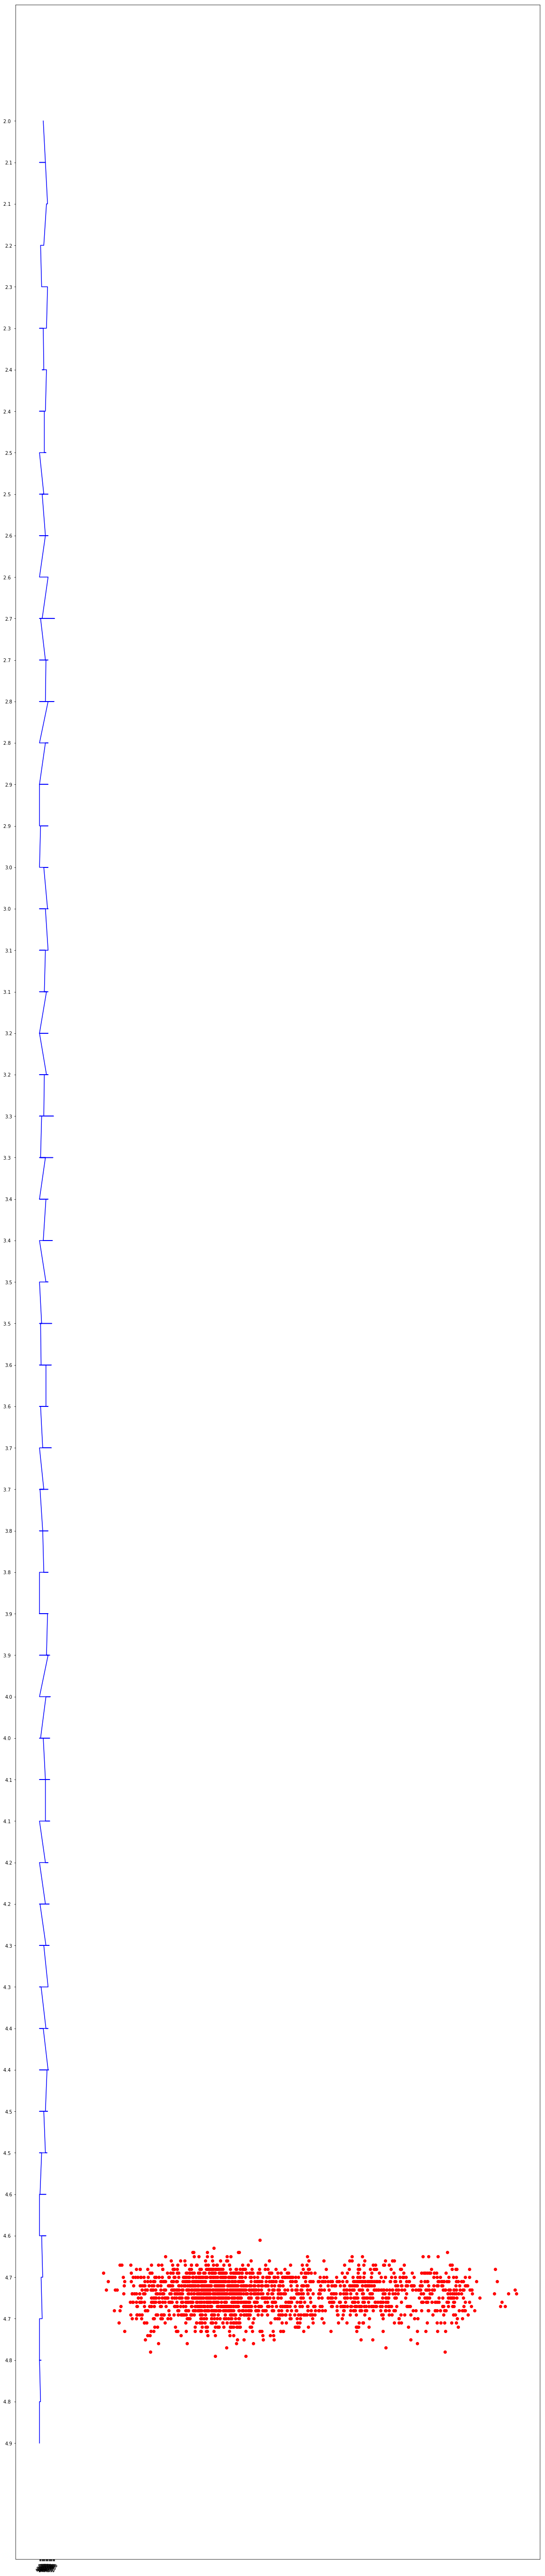

In [21]:
plt.figure(figsize=(20,100))
plt.plot(true_rating['actual'],true_rating['rate'],'-b',label='actual',)
plt.plot(predict_rating['predict'],predict_rating['rate'],'ro',label='predict')
plt.xticks(rotation='60')
plt.show()

### Tuning the Model

Due to advantages of a Random Forest Regressor over Linear Regression in context to the overfitting avoidance and better accuracy we selected the model for futher tuning.

To tune the model we have used 2 approaches
1. RandomizedSearch Cross Validation
This approach search based on hyperparameters. It implements a fit and score method that can be used to fit the model and evaluate the score respectively. The parameters of the estimator used by this method are optimized using cross validation.

2. GridSearch Cross Validation
This approach search based on specified parameter values. It also implements a fit and score method that can be used to fit the model and evaluate the score respectively.

The only difference between GridSearchCV and RandomizedSearchCV is that GridSearchCV is computationally expensive as compared to RandomizedSearchCV because RandomizedSearchCV uses a fixed number of parameters whereas GridSearchCV uses all the available parameters.

Because of the computational overhead, we have chosen RandomizedSearchCV over GridSearchCV.

After implementing the tuning approaches we found that the accuracy of the base model (Random Forest Regressor) has been affected significantly. The base model tends to overfit the data therefore on tuning with multiple depth,splits and leaves the accuracy got effected.


In [19]:
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

# Create the random grid
random_grid = {'bootstrap': [True,False],
               'max_depth': [80, 90, 100, 110],
               'max_features': [1,2,3,4],
               'min_samples_leaf': [3, 4, 5],
               'min_samples_split': [8, 10, 12],
               'n_estimators': [100, 200,350,500,1000]
              }
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 3, cv = 2, verbose=2, random_state=42, n_jobs = 1)
rf_random.fit(train_data, train_labelledData)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] n_estimators=200, min_samples_split=8, min_samples_leaf=3, max_features=2, max_depth=100, bootstrap=False 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=200, min_samples_split=8, min_samples_leaf=3, max_features=2, max_depth=100, bootstrap=False, total=   0.2s
[CV] n_estimators=200, min_samples_split=8, min_samples_leaf=3, max_features=2, max_depth=100, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=8, min_samples_leaf=3, max_features=2, max_depth=100, bootstrap=False, total=   0.1s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=3, max_features=4, max_depth=80, bootstrap=False 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=3, max_features=4, max_depth=80, bootstrap=False, total=   0.1s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=3, max_features=4, max_depth=80, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=3, max_features=4, max_depth=80, bootstrap=False, total=   0.1s
[CV] n_estimators=1000, min_samples_split=8, min_samples_leaf=5, max_features=1, max_depth=110, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=8, min_samples_leaf=5, max_features=1, max_depth=110, bootstrap=False, total=   0.5s
[CV] n_estimators=1000, min_samples_split=8, min_samples_leaf=5, max_features=1, max_depth=110, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=8, min_samples_leaf=5, max_features=1, max_depth=110, bootstrap=False, total=   0.6s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.9s finished


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=3, n_jobs=1,
          param_distributions={'bootstrap': [True, False], 'max_depth': [80, 90, 100, 110], 'max_features': [1, 2, 3, 4], 'min_samples_leaf': [3, 4, 5], 'min_samples_split': [8, 10, 12], 'n_estimators': [100, 200, 350, 500, 1000]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [20]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 10,
 'min_samples_leaf': 3,
 'max_features': 4,
 'max_depth': 80,
 'bootstrap': False}

In [22]:
best_random = rf_random.best_estimator_
modelPrediction = best_random.predict(test_data)
modelError = abs(modelPrediction - test_labelledData)
print('Mean Absolute Error:', round(np.mean(modelError), 2), 'degrees.')
meanAbsError = 100 * (modelError / test_labelledData)
accuracy = 100 - np.mean(meanAbsError)
print('Model Accuracy:', round(accuracy, 3), '%')

Mean Absolute Error: 156.2 degrees.
Model Accuracy: 49.05 %


In [23]:
#Reference: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

# Create the grid for Grid Search
GridSearchCV_grid = {'bootstrap': [True,False],
               'max_depth': [80, 90, 100, 110],
               'max_features': [1,2,3,4],
               'min_samples_leaf': [3, 4, 5],
               'min_samples_split': [8, 10, 12],
               'n_estimators': [100, 200,350,500,1000]
              }
rf = RandomForestRegressor()
rf_grid = GridSearchCV(estimator = rf, param_grid = GridSearchCV_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
rf_grid.fit(train_data, train_labelledData)

Fitting 3 folds for each of 1440 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  7.6min
[Para

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'bootstrap': [True, False], 'max_depth': [80, 90, 100, 110], 'max_features': [1, 2, 3, 4], 'min_samples_leaf': [3, 4, 5], 'min_samples_split': [8, 10, 12], 'n_estimators': [100, 200, 350, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [24]:
rf_grid.best_params_

{'bootstrap': False,
 'max_depth': 90,
 'max_features': 4,
 'min_samples_leaf': 3,
 'min_samples_split': 12,
 'n_estimators': 100}

In [25]:
choose_best_grid = rf_grid.best_estimator_
modelPrediction = choose_best_grid.predict(test_data)
modelError = abs(modelPrediction - test_labelledData)
print('Mean Absolute Error: ', round(np.mean(modelError), 2))
meanAbsError = 100 * (modelError / test_labelledData)
accuracy = 100 - np.mean(meanAbsError)
print('Model Accuracy: ', round(accuracy, 2), '%')

Mean Absolute Error:  155.52
Model Accuracy:  49.26 %
